In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.0+cu111  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


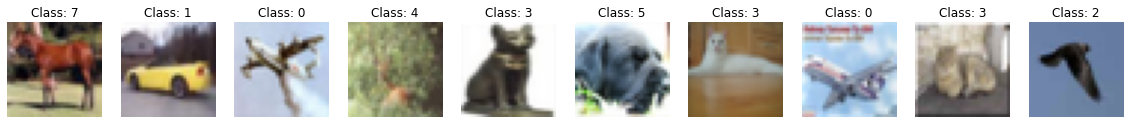

In [7]:
pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0))) # 순서 바뀜에 주의 (채널=3)
    plt.title('Class: ' + str(y_train[i].item()))

# MLP 모델 구현

In [7]:
class Net(nn.Module):
    def __init__(self):             # Net 객체 (인스턴스) 생성시 수행되는 코드
        super(Net, self).__init__() # nn_Modeule의 메소드를 수행
        self.fc1 = nn.Linear(32 * 32 * 3, 512) # MLP는 벡터만 입력으로 받는다
        self.fc2 = nn.Linear(512, 256)  # 중간 히든 레이어
        self.fc3 = nn.Linear(256, 10)   # 출력 레이어

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)     # Flatten()
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x 

In [8]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
# 학습 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()   # 앞에서 정의한 model을 학습 상태로
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() # 이전의 그라디언트 초기화
        output = model(image) # 출력을 계산
        loss = criterion(output, label) # 손실함수를 계산
        loss.backward() # 역전파 수행
        optimizer.step() # 파라미터 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [9]:
# 모델 검증 함수
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():   # 그라디언트의 흐름을 정지
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1] # 출력값 (확률) 중 가장 큰 값의 위치 찾기
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
# MLP 모델 훈련 및 검증 수행
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.316596
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.352781
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.020357
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.870728
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.941188
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.616006
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.691841
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.864536

[EPOCH: 1], 	Test Loss: 1.6849, 	Test Accuracy: 40.07 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.673441
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.867779
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.613455
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.159490
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.917630
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.454302
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.749924
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.650088

[EPOCH: 2], 	Test Loss: 1.6257, 	Test Accuracy: 41.72 % 

## 분류 성능이 약 48% 나온다

# CNN 모델 사용
- MLP 대신 CNN 모델을 사용한다
- 정확도 성능이 63%로 개선된다

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [12]:
# 모델 변경
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

NameError: ignored

In [11]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.311820
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.058368
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.568340
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.537401
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.582399
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.757715
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.670836
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.312850

[EPOCH: 1], 	Test Loss: 1.4263, 	Test Accuracy: 47.98 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.407992
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.671893
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.319656
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.680392
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.166500
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.236268
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.475335
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.188152

[EPOCH: 2], 	Test Loss: 1.2950, 	Test Accuracy: 53.22 % 

# 데이터 증식
- torchvision의 transform.Compose() 함수를 사용한다
- train_dataset, test_dataset 부분을 수정한다
 - 좌우 반전을 랜덤하게 수행하고, 정규화를 수행한다
- 성능이 66%로 개선된다

In [12]:
# 데이터 증식을 적용한다
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


Files already downloaded and verified


In [13]:
# 훈련과 검증
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 3.083650
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 0.923604
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 0.977072
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 0.637245
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 0.905456
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.234094
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.932294
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.674169

[EPOCH: 1], 	Test Loss: 1.0499, 	Test Accuracy: 62.93 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.876933
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.870300
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.299914
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.762647
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.854388
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.937832
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.193751
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.736826

[EPOCH: 2], 	Test Loss: 1.0190, 	Test Accuracy: 64.18 % 

# 기본적인 CNN을 개선한 ResNet을 사용
- 이미 만들어진 모델을 불러서 사용할 수 있다
- ResNet34 사용하기
 - 모델이 커서 시간이 오래 걸린다
 - 성능이 77% 정도 나온다

In [10]:
import torchvision.models as models
model = models.resnet34(pretrained = False) # 모델 구조만 사용한다
num_ftrs = model.fc.in_features # 출력단 카테고리 수를 불러온다 (1000개일 것)
model.fc = nn.Linear(num_ftrs, 10) # 출력 수를 10개로 조정한다
model = model.cuda() # model.to(DEVICE) 와 같다. 디바이스에 할당한다

In [13]:
# 환경 설정
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 훈련과 검증
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.634893
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.502302
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.342840
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.743231
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.658792
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.595101
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.204781
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.892307

[EPOCH: 1], 	Test Loss: 1.2407, 	Test Accuracy: 55.17 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.339154
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.303321
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.953498
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.223533
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.128178
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.089300
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.067464
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.217790

[EPOCH: 2], 	Test Loss: 1.3376, 	Test Accuracy: 56.87 % 

## 모델 구조와 함께 (ImageNet으로)사전 학습된 파라미터도 불러온다
- pretrained = True로 설정
- 성능이 81%로 개선된다

In [ ]:
model = models.resnet34(pretrained = True) # 사전학습된 파라미터도 불러온다
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))